In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
from mlxtend.data import loadlocal_mnist
train_x_orig, train_y = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

test_x_orig, test_y = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte',
        labels_path='t10k-labels.idx1-ubyte')

In [3]:
def convert(y):
    num_classes = 10
    num_examples = len(y)
    one_hot = np.zeros((num_classes, num_examples))
    one_hot[y, np.arange(num_examples)] = 1
    return one_hot


def read(x):
    return int(np.where(x == 1)[0])


def sigmoid(Z):    
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=0)
    

def cross_entropy(logits, labels):
    y = labels.argmax(axis=1)
    m = y.shape[0]
    p = softmax(logits)
    log_likehood = -np.log(p[range(m),y])
    loss = np.sum(log_likehood) / m
    return loss
    
    
def delta_cross_entropy(logits, labels):
    y = labels.argmax(axis=1)
    m = y.shape[0]
    grad = softmax(logits)
    grad[range(m),y] -= 1
    grad = grad / m
    return grad


def initialize_adam(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)

    return v, s
    
    
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W'+str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)]-learning_rate*grads['db'+str(l+1)]
    return parameters


def update_parameters_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                           beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta1 * v['db' + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]
        
        v_corrected['dW' + str(l+1)] = v['dW' + str(l+1)] / (1-beta1**t)
        v_corrected['db' + str(l+1)] = v['db' + str(l+1)] / (1-beta1**t)
        
        s['dW' + str(l+1)] = beta2 * s['dW' + str(l+1)] + (1-beta2) * grads['dW' + str(l+1)]**2
        s['db' + str(l+1)] = beta2 * s['db' + str(l+1)] + (1-beta2) * grads['db' + str(l+1)]**2
        
        s_corrected['dW' + str(l+1)] = s['dW' + str(l+1)] / (1-beta2**t)
        s_corrected['db' + str(l+1)] = s['db' + str(l+1)] / (1-beta2**t)
        
        parameters['W' + str(l+1)] = parameters['W'+str(l+1)] - learning_rate * v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon)
        parameters['b' + str(l+1)] = parameters['b'+str(l+1)] - learning_rate * v_corrected['db' + str(l+1)] / (np.sqrt(s_corrected['db' + str(l+1)]) + epsilon)
        
    return parameters, v, s
        

In [4]:
#reshape data
train_x_orig = np.reshape(train_x_orig, (train_x_orig.shape[0],28,28))
test_x_orig = np.reshape(test_x_orig, (test_x_orig.shape[0],28,28))

#labels
train_y = convert(train_y)
test_y = convert(test_y)

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 1)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 60000
Number of testing examples: 10000
Each image is of size: (28, 28, 1)
train_x_orig shape: (60000, 28, 28)
train_y shape: (10, 60000)
test_x_orig shape: (10000, 28, 28)
test_y shape: (10, 10000)


y = 3. It's a 3 picture.


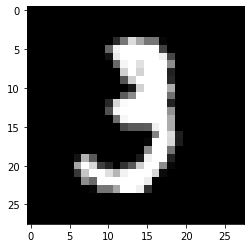

In [6]:
# Example of a picture
index = 10
first_image = np.array(train_x_orig[index], dtype='float')
plt.imshow(first_image)
print ("y = " + str(read(train_y[:,index])) + ". It's a " +str(read(train_y[:,index])) +  " picture.")

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward(A_prev, W, b):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (np.dot(dZ,A_prev.T))/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [9]:
# Initialize parameters
# forward prop
# Layer: Z -> relu
# Final layer: Z -> softmax

# cost func: softmax + loss
# back prop: linear back, relu back, softmax back?
# grad descent

In [10]:
def model(X, Y, layers_dims, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,
          num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    v,s = initialize_adam(parameters)
    t = 0
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU
        A1, cache1 = linear_activation_forward(X, W1, b1)
        A2, cache2 = linear_forward(A1, W2, b2)
        
        # Compute cost
        #cost = compute_cost(A2, Y)
        cost = cross_entropy(A2, Y)
        
        # Initializing backward propagation
        #dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA2 = softmax(A2) - Y
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_backward(dA2,cache2)
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1)
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        t = t + 1
        parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.3065283395532954
Cost after iteration 100: 0.0006834049637804026
Cost after iteration 200: 0.0004473883891986185
Cost after iteration 300: 0.0004131744703003198
Cost after iteration 400: 0.0003852966602176997
Cost after iteration 500: 0.00028442977559038597
Cost after iteration 600: 0.00021571377461905198
Cost after iteration 700: 0.0001681239334860547
Cost after iteration 800: 0.00013682622233763224
Cost after iteration 900: 0.00010913811192090318
Cost after iteration 1000: 8.801680024135021e-05
Cost after iteration 1100: 7.280340706153426e-05
Cost after iteration 1200: 6.04237764568936e-05
Cost after iteration 1300: 5.113919971186531e-05
Cost after iteration 1400: 4.408622716936703e-05
Cost after iteration 1500: 3.790025847288088e-05
Cost after iteration 1600: 3.300144563568278e-05
Cost after iteration 1700: 2.887650171214305e-05
Cost after iteration 1800: 2.5593652646503874e-05
Cost after iteration 1900: 2.2944210351659582e-05
Cost after iteration 2000: 2.0

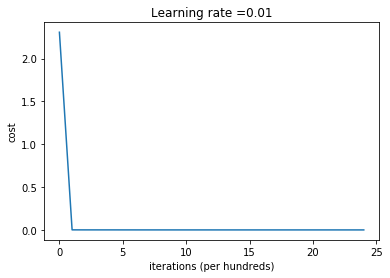

In [11]:
parameters = model(train_x, train_y, layers_dims = (784, 500, 10), num_iterations = 2500, print_cost=True)

In [12]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters)
    p = np.zeros((1,m))
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    A1, cache1 = linear_activation_forward(X, W1, b1)
    A2, cache2 = linear_forward(A1, W2, b2)
    test_loss = cross_entropy(A2, y)
    pred = np.max(softmax(A2),axis=0,keepdims=1) == softmax(A2)
    correct = np.sum(pred == y)
    print("test loss = %f, test accuracy = %f" %(test_loss, 100. * correct/m/10))

In [13]:
predict(train_x, train_y, parameters)
predict(test_x, test_y, parameters)

test loss = 0.000012, test accuracy = 100.000000
test loss = 0.000147, test accuracy = 99.536000
